<a href="https://colab.research.google.com/github/YairYarden/DeepCascadingAMC/blob/feature%2Fdivide_between_qams/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [11]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Chose Device

In [12]:
# check if CUDA is available
import torch
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is available!  Training on GPU ...


# Load Python Files

In [28]:
# Load files 
from google.colab import files

# Dataset Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/encoder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset_builder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/rml_2016.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_SNR_groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_QAMs_Snrs_Groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_MergedQAMs_Snrs_Groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/snr_encoder.py /content

# Utils Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/utils/plot.py /content

# Training Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/accuracy.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/confusion.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/baseModel.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/cldnn.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/flatten.py /content



# Import Functions & Classes

In [31]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
# Data
from dataset import Dataset
from encoder import Encoder
from rml_2016 import load_RML201610B_dataset
from RML2016_SNR_groups_DataLoader import load_RML201610B_dividedBySNR
from RML2016_QAMs_Snrs_Groups_DataLoader import load_RML201610B_onlyQAMs_dividedBySNR
# from RML2016_MergedQAMs_Snrs_Groups_DataLoader import load_RML201610B_MergedQAMs_dividedBySNR


from snr_encoder import SNREncoder

# Utils
from plot import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

# Training
from accuracy import compute_accuracy, compute_accuracy_on_cross_sections
#from accuracy import compute_cascaded_sen_amc_accuracy
from confusion import compute_confusion
from baseModel import Model
from cldnn import CLDNN


In [32]:
from collections import defaultdict
import numpy as np
import os
import pickle
import tarfile
from typing import Tuple, Dict
from urllib.request import urlretrieve
from warnings import warn

# Internal Includes
from dataset import Dataset
from dataset_builder import DatasetBuilder

class RML2016_MergedQAMs_SNR_groups_DataLoader(object):
    def __init__(
        self, cache_path: str, remote_url: str, unpickled_path: str, warning_msg: str
    ):
        self.CACHE_PATH = cache_path
        self.REMOTE_URL = remote_url
        self.UNPICKLED_PATH = unpickled_path
        self.WARNING_MSG = warning_msg

    def load(self, path: str):
        if path is not None:
            if not os.path.exists(path):
                raise ValueError(
                    "If path is provided, it must actually exist.  Provided path: "
                    "{}".format(path)
                )
            return self._load_local(path=path)

        # If this function has previously been called before to fetch the dataset from the
        # remote, then it will have already been cached locally and unpickled.
        if os.path.exists(self.UNPICKLED_PATH):
            return self._load_local(self.UNPICKLED_PATH)

        warn(self.WARNING_MSG)
        self._download()
        return self._load_local(self.UNPICKLED_PATH)

    def _load_local(self, path: str) -> Dataset:
        builder_lowSNR = DatasetBuilder()
        builder_mediumSNR = DatasetBuilder()
        builder_highSNR = DatasetBuilder()
        data, description = self._read(path)
        for mod, snrs in description.items():          
            for snr in snrs:
                for iq in data[(mod, snr)]:
                    if(snr <= -10):
                        if(mod != "QAM16" and mod != "QAM64"):
                            builder_lowSNR.add(iq=iq, Modulation=mod, SNR=snr)
                        else:
                            builder_lowSNR.add(iq=iq, Modulation="QAM", SNR=snr)
                            
                    elif(snr <= 4):
                        if(mod != "QAM16" and mod != "QAM64"):
                            builder_mediumSNR.add(iq=iq, Modulation=mod, SNR=snr)
                        else:
                            builder_mediumSNR.add(iq=iq, Modulation="QAM", SNR=snr)
                            
                    else:
                        if(mod != "QAM16" and mod != "QAM64"):
                            builder_highSNR.add(iq=iq, Modulation=mod, SNR=snr)
                        else:
                            builder_highSNR.add(iq=iq, Modulation="QAM", SNR=snr)
                                     
        return builder_lowSNR.build(), builder_mediumSNR.build(), builder_highSNR.build() 

    def _download(self):
        urlretrieve(self.REMOTE_URL, self.CACHE_PATH)
        with tarfile.open(self.CACHE_PATH, "r:bz2") as tar:
            tar.extractall()

    def _read(self, path: str) -> Tuple[np.ndarray, Dict]:
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin")

            description = defaultdict(list)
            # Declare j just to get the linter to stop complaining about the lamba below
            j = None
            snrs, mods = map(
                lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1, 0]
            )
            for mod in mods:
                for snr in snrs:
                    description[mod].append(snr)

            return data, description
            

def load_RML201610B_MergedQAMs_dividedBySNR(path: str = None) -> Dataset:
    """Load the RadioML2016.10B Dataset provided by DeepSig Inc.

    This dataset is licensed under Creative Commons Attribution - NonCommercial -
    ShareAlike 4.0 License (CC BY-NC-SA 4.0) by DeepSig Inc.

    Args:
        path (str, optional): Path to the dataset which has already been downloaded from
                              DeepSig Inc., saved locally, and extracted (tar xjf).  If
                              not provided, the dataset will attempt to be downloaded
                              from the internet and saved locally -- subsequent calls
                              would read from that cached dataset that is fetched.

    Raises:
        ValueError: If *path* is provided but does not exist.

    Returns:
        Dataset: A Dataset that has been loaded with the data from RML2016.10B

    License
        https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode

    Download Location
        https://www.deepsig.io/datasets

    Citation
        T. J. O’Shea and N. West, “Radio machine learning dataset generation with GNU
        Radio” in Proceedings of the GNU Radio Conference, vol. 1, 2016.
    """
    CACHE_PATH = "./RML2016.10b.tar.bz2"
    WARNING_MSG = """
    About to attempt downloading the RML2016.10B dataset from deepsig.io/datasets.
    Depending on your network connection, this process can be slow and error prone.  Any
    errors raised during network operations are not silenced and will therefore cause your
    code to crash.  If you require robustness in your experimentation, you should manually
    download the file locally and pass the file path to the load_RML201610b_dataset
    function.

    Further, this dataset is provided by DeepSig Inc. under Creative Commons Attribution
    - NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0).  By calling this function,
    you agree to that license -- If an alternative license is needed, please contact DeepSig
    Inc. at info@deepsig.io
    """
    REMOTE_URL = "http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2"
    UNPICKLED_PATH = "RML2016.10b.dat"

    loader = RML2016_MergedQAMs_SNR_groups_DataLoader(
        cache_path=CACHE_PATH,
        remote_url=REMOTE_URL,
        unpickled_path=UNPICKLED_PATH,
        warning_msg=WARNING_MSG,
    )
    return loader.load(path=path)           

# Load Dataset

## Load 

In [34]:
# Load
import os
drive_path = '/content/drive/MyDrive/Deep_learning_05107255/project'
data_path = os.path.join(drive_path, 'RadioML2016_b/RML2016.10b.dat')
# FULL Dataset
dataset = load_RML201610B_dataset(path=data_path)
# Print
print(len(dataset))
pprint(dataset.get_examples_per_class())

1200000
{'8PSK': 120000,
 'AM-DSB': 120000,
 'BPSK': 120000,
 'CPFSK': 120000,
 'GFSK': 120000,
 'PAM4': 120000,
 'QAM16': 120000,
 'QAM64': 120000,
 'QPSK': 120000,
 'WBFM': 120000}


In [35]:
# Dataset divided to 3 SNR Groups
# datasetLow, dataMed, datasetHigh = load_RML201610B_dividedBySNR(path=data_path)
datasetLow, dataMed, datasetHigh = load_RML201610B_MergedQAMs_dividedBySNR(path = data_path) # Merged Qams


# Only QAMs divided to 3 SNR Groups
datasetLowQams, dataMedQams, datasetHighQams = load_RML201610B_onlyQAMs_dividedBySNR(path=data_path)

# Print
print('Num examples High SNR :', len(datasetHigh))
print('Num examples Medium SNR :', len(dataMed))
print('Num examples Low SNR :', len(datasetLow))
print('High SNR per class examples :')
pprint(datasetHigh.get_examples_per_class())

# Print only QAMs
print('High SNR QAMs examples per class : ')
pprint(datasetHighQams.get_examples_per_class())



Num examples High SNR : 420000
Num examples Medium SNR : 420000
Num examples Low SNR : 360000
High SNR per class examples :
{'8PSK': 42000,
 'AM-DSB': 42000,
 'BPSK': 42000,
 'CPFSK': 42000,
 'GFSK': 42000,
 'PAM4': 42000,
 'QAM': 84000,
 'QPSK': 42000,
 'WBFM': 42000}
High SNR QAMs examples per class : 
{'QAM16': 42000, 'QAM64': 42000}


## Split to Train - Val - Test

In [37]:
# All together
train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
train, val = train.split(frac=0.05, on=["Modulation", "SNR"])
# -----------------------------------------------------------------
# Splitted to SNR
# High
train_high_snr, test_high_snr = datasetHigh.split(frac=0.3, on=["Modulation", "SNR"])
train_high_snr, val_high_snr = train_high_snr.split(frac=0.05, on=["Modulation", "SNR"])
# medium
train_med_snr, test_med_snr = dataMed.split(frac=0.3, on=["Modulation", "SNR"])
train_med_snr, val_med_snr = train_med_snr.split(frac=0.05, on=["Modulation", "SNR"])
# low
train_low_snr, test_low_snr = datasetLow.split(frac=0.3, on=["Modulation", "SNR"])
train_low_snr, val_low_snr = train_low_snr.split(frac=0.05, on=["Modulation", "SNR"])
# -----------------------------------------------------------------
# Splitted QAMs to train & test
train_Qams_high_snr, test_Qams_high_snr = datasetHighQams.split(frac=0.3, on=["Modulation", "SNR"])
train_Qams_high_snr, val_Qams_high_snr = train_Qams_high_snr.split(frac=0.05, on=["Modulation", "SNR"])

train_Qams_med_snr, test_Qams_med_snr = dataMedQams.split(frac=0.3, on=["Modulation", "SNR"])
train_Qams_med_snr, val_Qams_med_snr = train_Qams_med_snr.split(frac=0.05, on=["Modulation", "SNR"])

train_Qams_low_snr, test_Qams_low_snr = datasetLowQams.split(frac=0.3, on=["Modulation", "SNR"])
train_Qams_low_snr, val_Qams_low_snr = train_Qams_low_snr.split(frac=0.05, on=["Modulation", "SNR"])
# -----------------------------------------------------------------
print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")


Training Examples
{'8PSK': 79780,
 'AM-DSB': 79780,
 'BPSK': 79780,
 'CPFSK': 79780,
 'GFSK': 79780,
 'PAM4': 79780,
 'QAM16': 79780,
 'QAM64': 79780,
 'QPSK': 79780,
 'WBFM': 79780}

Validation Examples
{'8PSK': 4200,
 'AM-DSB': 4200,
 'BPSK': 4200,
 'CPFSK': 4200,
 'GFSK': 4200,
 'PAM4': 4200,
 'QAM16': 4200,
 'QAM64': 4200,
 'QPSK': 4200,
 'WBFM': 4200}

Testing Examples
{'8PSK': 36020,
 'AM-DSB': 36020,
 'BPSK': 36020,
 'CPFSK': 36020,
 'GFSK': 36020,
 'PAM4': 36020,
 'QAM16': 36020,
 'QAM64': 36020,
 'QPSK': 36020,
 'WBFM': 36020}
{'8PSK': 27923,
 'AM-DSB': 27923,
 'BPSK': 27923,
 'CPFSK': 27923,
 'GFSK': 27923,
 'PAM4': 27923,
 'QAM': 55853,
 'QPSK': 27923,
 'WBFM': 27923}


## SNR encoder

In [38]:
snr_enc = SNREncoder(label_name="SNR")


## Labels encoder

In [39]:
le = Encoder(["WBFM",
              "AM-DSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM"],
             label_name="Modulation")
print('All labels : ')
print(le)

le_QAMs = Encoder(["QAM16",
                   "QAM64"],
                   label_name="Modulation")

print('QAMs labels : ')
print(le_QAMs)


All labels : 
WBFM: 0
AM-DSB: 1
CPFSK: 2
GFSK: 3
BPSK: 4
QPSK: 5
8PSK: 6
PAM4: 7
QAM: 8

QAMs labels : 
QAM16: 0
QAM64: 1



## Plot Example

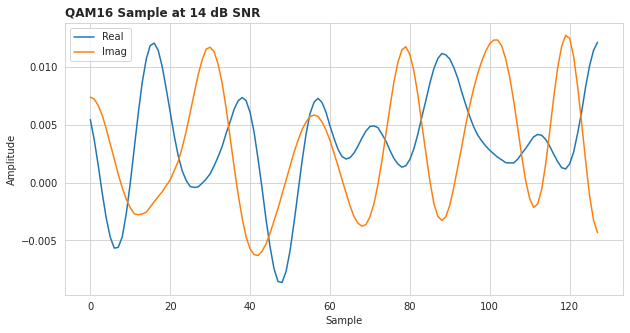

In [16]:
fig_dir = None
import random

# Plot a sample of the data
# You can choose a different sample by changing
# idx = 14
idx = random.randint(0, 200)
snr = 14
modulation = "QAM16"

mask = (train_Qams_high_snr.df["SNR"] == snr) & (train_Qams_high_snr.df["Modulation"] == modulation)
sample = train_Qams_high_snr.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()



# Model

In [40]:
class CNN1(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        self.conv3 = nn.Conv2d(
            in_channels=80,
            out_channels=30,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )

        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm2d(30)

        # Batch x Features
        self.dense1 = nn.Linear(30 * 1 * input_samples, 256)
        self.a4 = nn.ReLU()
        self.n4 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        x = self.conv3(x)
        x = self.a3(x)
        x = self.n3(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a4(x)
        x = self.n4(x)

        x = self.dense2(x)

        return x

cnn1Model = CNN1(input_samples=128, n_classes=9)
print(cnn1Model) 

cldnnModel = CLDNN(input_samples = 128, n_classes = 2)
print(cldnnModel)

CNN1(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(80, 30, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a3): ReLU()
  (n3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=3840, out_features=256, bias=True)
  (a4): ReLU()
  (n4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=9, bias=True)
)
----------------------
Trainable Parameters: 1165715
Fixed Parameters: 0
Total Parameters: 1165715
----------------------

CLDNN(
  (conv1): Conv2d(1, 50, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3),

# Training Functions

In [41]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 3, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            model, train_loss = self._train_one_epoch(model=model, data=train_data, loss_fn=criterion, optimizer=optimizer)

            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return model, ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return model, mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

# ----------------------------------------------------------------- #
from datetime import datetime 
def save_model(model, dir_path, name):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  model_name = name + '_' + model_name
  
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')

In [44]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu)
# print(trainer)
# trainer.lr = 1e-5
# trainer.n_epochs = 5
# print(trainer)

# Train the network

## Train on all examples

In [ ]:
model_allSNR, train_loss_allSNR, val_loss_allSNR = trainer(model=model, training=train, validation=val, le=le)

On Epoch 0 the training loss was 0.9800630400699251
---- validation loss was 0.9515002362699394
On Epoch 1 the training loss was 0.9428590792276066
---- validation loss was 0.9544099856571979
On Epoch 2 the training loss was 0.9259567410231707
---- validation loss was 0.947456399360335


## Train By SNR groups

### High SNR (6 : 18[dB])

In [45]:
cnn1Model = CNN1(input_samples=128, n_classes=9)
trainer = MyTrainingStrategy(gpu=gpu)
model_highSNR, train_loss_highSNR, val_loss_highSNR = trainer(model=cnn1Model, training=train_high_snr, validation=val_high_snr, le=le)



On Epoch 0 the training loss was 0.280038558328763
---- validation loss was 0.17507920131601137
On Epoch 1 the training loss was 0.15433456623183064
---- validation loss was 0.14495623497099713
On Epoch 2 the training loss was 0.13651362416290103
---- validation loss was 0.1636771364458676


### Medium SNR (-8 : 4 [dB])

In [ ]:
model_medSNR, train_loss_medSNR, val_loss_medSNR = trainer(model=model, training=train_med_snr, validation=val_med_snr, le=le)


On Epoch 0 the training loss was 0.7001809299865485
---- validation loss was 0.6281697462344992
On Epoch 1 the training loss was 0.6062524709509406
---- validation loss was 0.61386304888232
On Epoch 2 the training loss was 0.5726185834560639
---- validation loss was 0.590921845929376


### Low SNR (-20 : - 10 [dB])

In [ ]:
model_lowSNR, train_loss_lowSNR, val_loss_lowSNR = trainer(model=model, training=train_low_snr, validation=val_low_snr, le=le)


On Epoch 0 the training loss was 2.2136602666642933
---- validation loss was 2.2086414337158202
On Epoch 1 the training loss was 2.084619309657659
---- validation loss was 2.3752005004882815
On Epoch 2 the training loss was 2.069360450292245
---- validation loss was 2.1241593074798586


## Train SEN

In [ ]:
sen_model = CNN1(input_samples=128, n_classes=snr_enc.n_classes)
sen_model, sen_train_loss, sen_val_loss = trainer(model=sen_model, training=train, validation=val, le=snr_enc)

On Epoch 0 the training loss was 0.24195163230088523
---- validation loss was 0.22038345685206265
On Epoch 1 the training loss was 0.20000389449637695
---- validation loss was 0.2166745964303074
On Epoch 2 the training loss was 0.19256177008381403
---- validation loss was 0.1886318839458098


## Train only QAMs

### High SNR (6 : 18[dB])

In [49]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-4, n_epochs = 20)
qams_model = CLDNN(input_samples = 128, n_classes = 2)
qams_highSnr_model, qams_highSnr_train_loss, qams_highSnr_val_loss = trainer(model=qams_model, training=train_Qams_high_snr, validation=val_Qams_high_snr, le=le_QAMs)



On Epoch 0 the training loss was 0.7165452355688269
---- validation loss was 0.7111368576685587
On Epoch 1 the training loss was 0.7014871743592349
---- validation loss was 0.7111774384975433
On Epoch 2 the training loss was 0.6941281497478485
---- validation loss was 0.7081288496653239
On Epoch 3 the training loss was 0.6911080224947496
---- validation loss was 0.7095398704210917
On Epoch 4 the training loss was 0.6878368090499531
---- validation loss was 0.7071621119976044
On Epoch 5 the training loss was 0.6844593449072405
---- validation loss was 0.7045282026131948
On Epoch 6 the training loss was 0.6829279075969349
---- validation loss was 0.7059702376524607
On Epoch 7 the training loss was 0.6794473973187534
---- validation loss was 0.7058102091153463
On Epoch 8 the training loss was 0.6768608022819865
---- validation loss was 0.7060147424538931
On Epoch 9 the training loss was 0.674550161036578
---- validation loss was 0.7046390970547994
On Epoch 10 the training loss was 0.67162

### Medium SNR (-8 : 4 [dB])

In [71]:
trainer = MyTrainingStrategy(gpu=gpu, lr = 5e-5, n_epochs = 3)

# qams_model = CNN1(input_samples = 128, n_classes = 2)
# qams_model = CLDNN(input_samples = 128, n_classes = 2)
# qams_medSNR_model, qams_medSNR_train_loss, qams_medSNR_val_loss = trainer(model=qams_model, training=train_Qams_med_snr, validation=val_Qams_med_snr, le=le_QAMs)

qams_medSNR_model, qams_medSNR_train_loss, qams_medSNR_val_loss = trainer(model=qams_medSNR_model, training=train_Qams_med_snr, validation=val_Qams_med_snr, le=le_QAMs)

On Epoch 0 the training loss was 0.47109484645453364
---- validation loss was 0.50864477455616
On Epoch 1 the training loss was 0.4679145924069665
---- validation loss was 0.5087574323018392
On Epoch 2 the training loss was 0.46813027181408623
---- validation loss was 0.5089603215456009


### Low SNR (-20 : - 10 [dB])

In [85]:
trainer = MyTrainingStrategy(gpu=gpu, lr = 3e-5, n_epochs = 3)

# qams_model = CNN1(input_samples = 128, n_classes = 2)
# qams_model = CLDNN(input_samples = 128, n_classes = 2)
# qams_lowSNR_model, qams_lowSNR_train_loss, qams_lowSNR_val_loss = trainer(model=qams_model, training=train_Qams_low_snr, validation=val_Qams_low_snr, le=le_QAMs)

qams_medSNR_model, qams_medSNR_train_loss, qams_medSNR_val_loss = trainer(model=qams_medSNR_model, training=train_Qams_med_snr, validation=val_Qams_med_snr, le=le_QAMs)

On Epoch 0 the training loss was 0.43968045088377866
---- validation loss was 0.5066889425118765
On Epoch 1 the training loss was 0.43729178959673104
---- validation loss was 0.5072628855705261
On Epoch 2 the training loss was 0.4361435435035012
---- validation loss was 0.5072463701168696


## Plot results 

### All SNR's

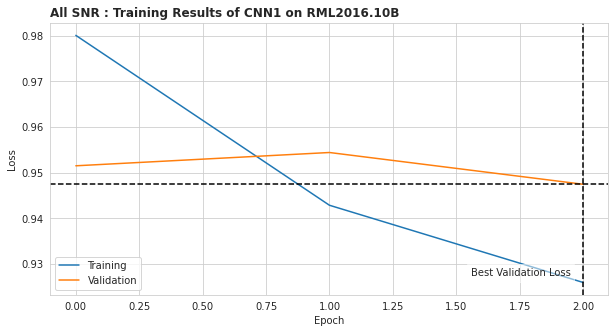

In [ ]:
title = "All SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_allSNR, val_loss=val_loss_allSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

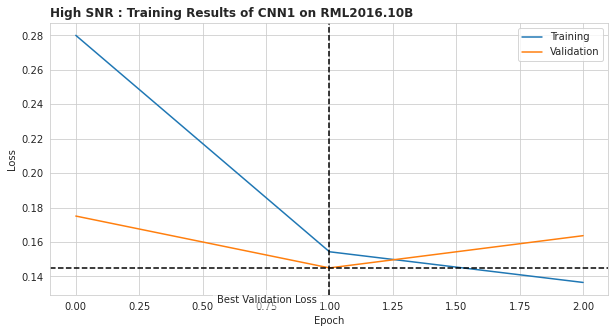

In [48]:
title = "High SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_highSNR, val_loss=val_loss_highSNR, title=title)

plt.show()

### Medium SNR

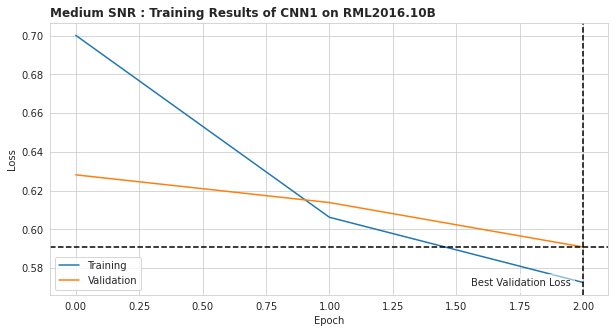

In [ ]:
title = "Medium SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_medSNR, val_loss=val_loss_medSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

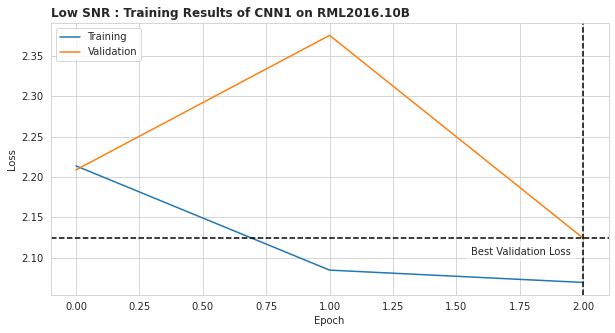

In [ ]:
title = "Low SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_lowSNR, val_loss=val_loss_lowSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### SEN

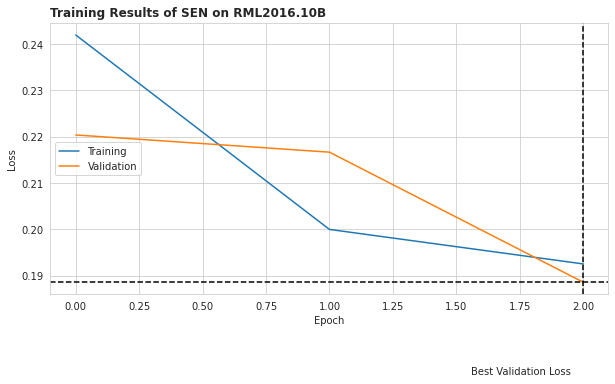

In [ ]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=sen_train_loss, val_loss=sen_val_loss, title=title)
plt.show()

# Save Model

In [87]:
# # all SNR
# save_model(model_allSNR, drive_path, 'allSNR_CNN1_AMC_3_epochs')
# # High SNR
# save_model(model_highSNR, drive_path, 'highSNRSnr_CNN1_AMC_3_epochs')
# # medium SNR
# save_model(model_medSNR, drive_path, 'medSNR_CNN1_AMC_3_epochs')
# # low SNR 
# save_model(model_lowSNR, drive_path, 'lowSNR_CNN1_AMC_3_epochs')
# # SEN model
# save_model(sen_model, drive_path, 'SEN_CNN1_3_epochs')

# qams_path = drive_path + '/Qams/'
save_model(qams_lowSNR_model, drive_path, 'qams_lowSnr_lr_1e4')



model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/qams_lowSnr_lr_1e4_22_08_26_12_03_58.ckpt"


# Load Pre-trained models

In [59]:
# ALL SNR
# allSNR_ckpt_path = f'{drive_path}/checkpoints/allSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# allSNR_checkpoint = torch.load(allSNR_ckpt_path)
# model_allSNR = CNN1(input_samples=128, n_classes=10)
# model_allSNR.load_state_dict(allSNR_checkpoint['model_state_dict'])

# HIGH SNR
# highSNR_ckpt_path = f'{drive_path}/checkpoints/highSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# highSNR_checkpoint = torch.load(highSNR_ckpt_path)
# model_highSNR = CNN1(input_samples=128, n_classes=10)
# model_highSNR.load_state_dict(highSNR_checkpoint['model_state_dict'])

# # MEDIUM SNR
# medSNR_ckpt_path = f'{drive_path}/checkpoints/medSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# medSNR_checkpoint = torch.load(medSNR_ckpt_path)
# model_medSNR = CNN1(input_samples=128, n_classes=10)
# model_medSNR.load_state_dict(medSNR_checkpoint['model_state_dict'])

# # LOW SNR
# lowSNR_ckpt_path = f'{drive_path}/checkpoints/lowSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# lowSNR_checkpoint = torch.load(lowSNR_ckpt_path)
# model_lowSNR = CNN1(input_samples=128, n_classes=10)
# model_lowSNR.load_state_dict(lowSNR_checkpoint['model_state_dict'])

# High SNR QAM
QamhighSNR_ckpt_path = f'{drive_path}/checkpoints/qams_highSnr_lr_1e4_22_08_26_11_15_19.ckpt'
QamhighSNR_checkpoint = torch.load(QamhighSNR_ckpt_path)
Qam_model_highSNR = CLDNN(input_samples=128, n_classes=2)
Qam_model_highSNR.load_state_dict(QamhighSNR_checkpoint['model_state_dict'])

<All keys matched successfully>

# Test Models seperately

## Overall Accuracy

### All SNR

In [ ]:
acc = compute_accuracy(model=model_allSNR, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.6330


### High SNR

In [49]:
acc = compute_accuracy(model=model_highSNR, data=test_high_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.9126


### Medium SNR

In [ ]:
acc = compute_accuracy(model=model_medSNR, data=test_med_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.7374


### Low SNR

In [ ]:
acc = compute_accuracy(model=model_lowSNR, data=test_low_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.1946


### SEN

In [ ]:
sen_acc = compute_accuracy(model=sen_model, data=test, le=snr_enc)
print("Overall Testing Accuracy: {:.4f}".format(sen_acc))

Overall Testing Accuracy: 0.9250


## Accuracy vs SNR

### All SNR

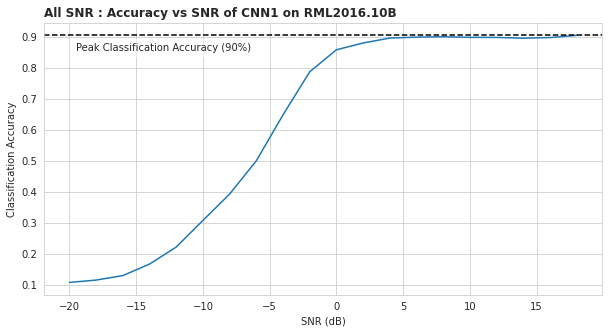

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_allSNR,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "All SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

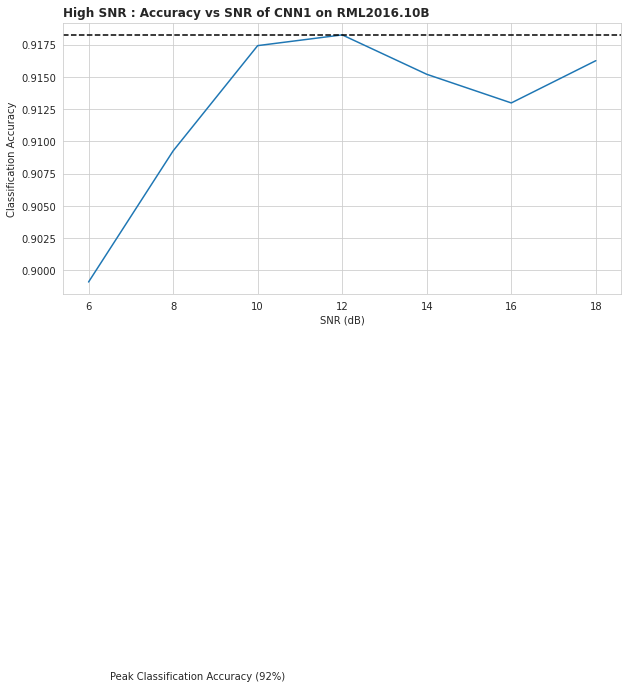

In [51]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_highSNR,
                                                     data=test_high_snr,
                                                     le=le,
                                                     column="SNR")

title = "High SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)

plt.show()


### Medium SNR

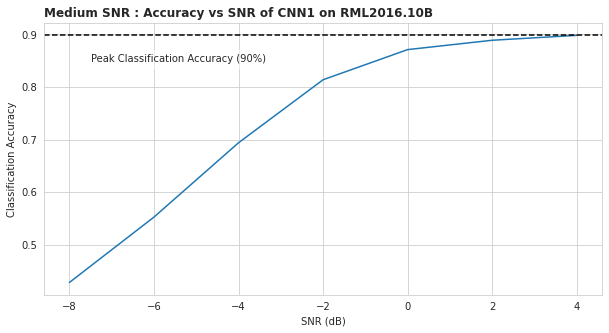

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_medSNR,
                                                     data=test_med_snr,
                                                     le=le,
                                                     column="SNR")

title = "Medium SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

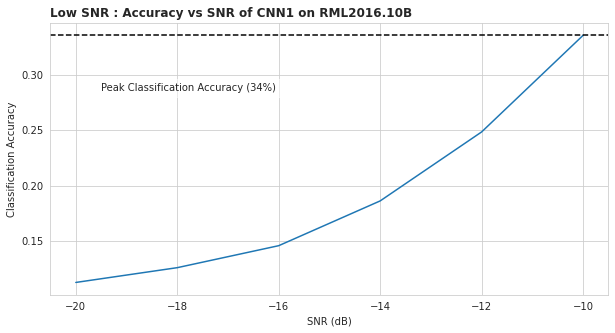

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_lowSNR,
                                                     data=test_low_snr,
                                                     le=le,
                                                     column="SNR")

title = "Low SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

## Confusion matrix

### All SNR

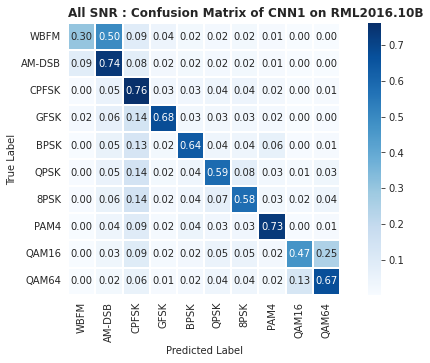

In [ ]:
cmn = compute_confusion(model=model_allSNR, data=test, le=le)

title = "All SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

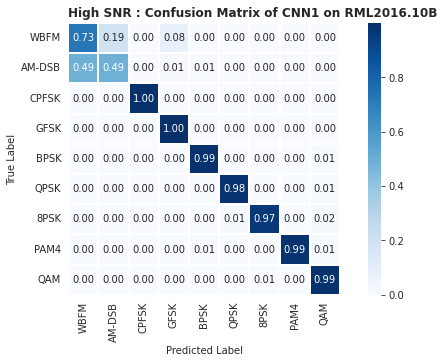

In [53]:
cmn = compute_confusion(model=model_highSNR, data=test_high_snr, le=le)

title = "High SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)

plt.show()

### Medium SNR

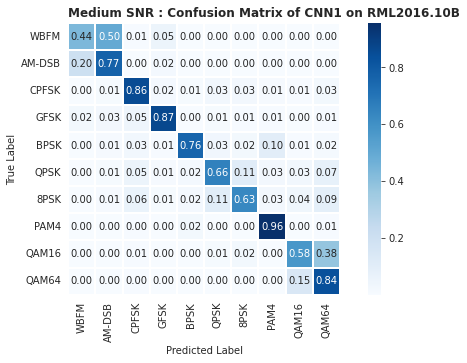

In [ ]:
cmn = compute_confusion(model=model_medSNR, data=test_med_snr, le=le)

title = "Medium SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

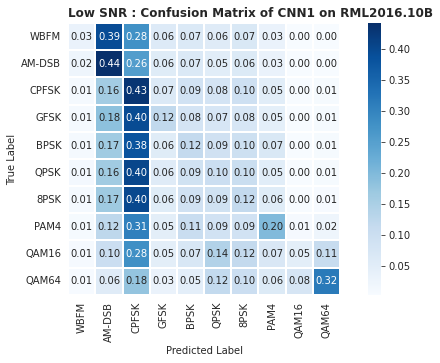

In [ ]:
cmn = compute_confusion(model=model_lowSNR, data=test_low_snr, le=le)

title = "Low SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### SEN

[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]


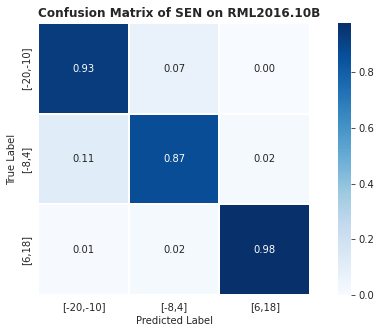

In [ ]:
sen_cmn = compute_confusion(model=sen_model, data=test, le=snr_enc)
title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_confusion(cm=sen_cmn, labels=snr_enc.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/sen_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)

plt.show()

### QAMs High SNR

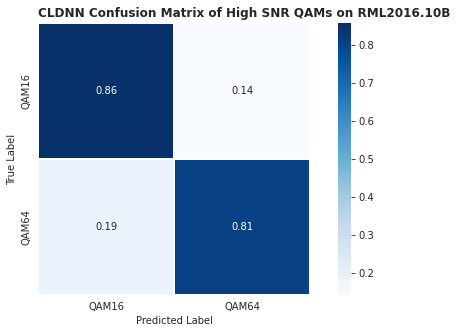

In [61]:
qams_cmn = compute_confusion(model=Qam_model_highSNR, data=test_Qams_high_snr, le=le_QAMs)
title = "CLDNN Confusion Matrix of High SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

### QAMs Medium SNR

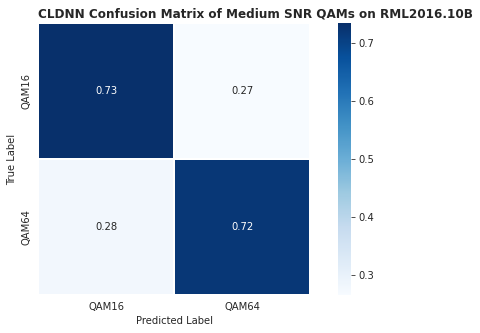

In [72]:
qams_cmn = compute_confusion(model=qams_medSNR_model, data=test_Qams_med_snr, le=le_QAMs)
title = "CLDNN Confusion Matrix of Medium SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

### QAMs Low SNR

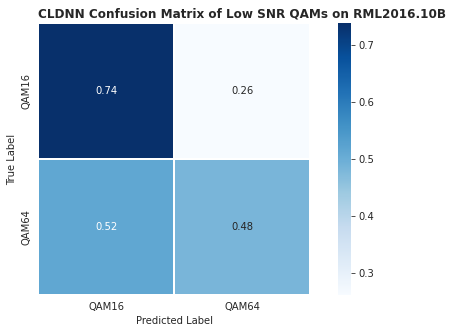

In [86]:
qams_cmn = compute_confusion(model=qams_lowSNR_model, data=test_Qams_low_snr, le=le_QAMs)
title = "CLDNN Confusion Matrix of Low SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

# Test Cascaded Models

## Compute Accuracy

In [ ]:
import pandas as pd

def compute_cascaded_sen_amc_accuracy(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> float:
    """Compute the Top-1 accuracy of this cascading SEN & AMC Models

    Args:
        senModel (senModel): (Trained) SEN model.
        highSNRModel (highSNRModel): (Trained) model to on high SNR.
        medSNRModel (medSNRModel): (Trained) model to on high SNR.
        lowSNRModel (lowSNRModel): (Trained) model to on high SNR.
        data (Dataset): (Testing) data to use for evaluation.
        le (Encoder): Mapping from human readable to machine readable.
        batch_size (int, optional): Defaults to 512.
        mask (pd.DataFrame.mask, optional): Mask to apply to the data before computing
                                            accuracy.  Defaults to None.

    Returns:
        float: Top-1 Accuracy - All SNR
        float: Top-1 Accuracy - High SNR
        float: Top-1 Accuracy - Med SNR
        float: Top-1 Accuracy - Low SNR
        
    """
    
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    rightLowSNR = 0
    rightMedSNR = 0
    rightHighSNR = 0
    
    nExamplesLowSNR = 0
    nExamplesMedSNR = 0
    nExamplesHighSNR = 0

    for _, data in enumerate(dl):
        inputs, labels = data
        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_labels =  labels[low_snr_indx]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)
          rightLowSNR += (low_snr_pred == low_snr_labels).sum().item()
          nExamplesLowSNR += len(low_snr_labels)

        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_labels =  labels[med_snr_indx]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)
          rightMedSNR += (med_snr_pred == med_snr_labels).sum().item()
          nExamplesMedSNR += len(med_snr_labels)

        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_labels = labels[high_snr_indx]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)
          rightHighSNR += (high_snr_pred == high_snr_labels).sum().item()
          nExamplesHighSNR += len(high_snr_labels)
    
    accLow = float(rightLowSNR) / nExamplesLowSNR
    accMed = float(rightMedSNR) / nExamplesMedSNR
    accHigh = float(rightHighSNR) / nExamplesHighSNR
    
    totalRight = rightLowSNR + rightMedSNR + rightHighSNR
    nTotalExamples = nExamplesLowSNR + nExamplesMedSNR + nExamplesHighSNR
    accAll = float(totalRight) / nTotalExamples
    
    return accAll, accHigh, accMed, accLow

In [ ]:
accAll, accHigh, accMed, accLow = compute_cascaded_sen_amc_accuracy(sen_model=sen_model, 
                                                                    high_snr_model = model_highSNR,
                                                                    med_snr_model = model_medSNR,
                                                                    low_snr_model = model_lowSNR,
                                                                    data=test, le=le)
print('ACC LOW : ', accLow)
print('ACC MED : ', accMed)
print('ACC HIGH : ', accHigh)
print('ACC ALL : ', accAll)

ACC LOW :  0.16233766233766234
ACC MED :  0.7701149425287356
ACC HIGH :  0.9021739130434783
ACC ALL :  0.634765625


## Confusion Matrix

In [ ]:

# External Includes
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from typing import List, Tuple

def compute_cascadedModel_confusion(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> np.ndarray:
   
    predictions, labels = _extract_cascaded_model_predictions_and_labels(sen_model=sen_model, high_snr_model=high_snr_model,
                                                                         med_snr_model=med_snr_model, low_snr_model=low_snr_model,
                                                                         data=data, le=le, batch_size=batch_size, mask=mask)
    return _confusion_matrix(predictions=predictions, labels=labels, le=le)


def _confusion_matrix(
    predictions: List[int], labels: List[int], le: Encoder
) -> np.ndarray:
    # Note: This could be replaced with sklearn.metrics.confusion_matrix
    # It is simply rewritten in order to avoid introducing a dependency for one thing
    confusion_matrix = np.zeros([len(le.labels), len(le.labels)])

    # Compute the total number of predictions
    for predicted_label, true_label in zip(predictions, labels):
        confusion_matrix[true_label, predicted_label] = (
            confusion_matrix[true_label, predicted_label] + 1.0
        )

    # Normalize these predictions to be a percentage
    for true_label in range(confusion_matrix.shape[0]):
        # Avoid a divide by zero case, no guarantee that we are calling this method
        # with data for all of the classes that could be predicted
        total = np.sum(confusion_matrix[true_label, :])

        if total == 0:
            confusion_matrix[true_label, :] = 0.0
        else:
            confusion_matrix[true_label, :] = confusion_matrix[true_label, :] / total

    return confusion_matrix


def _extract_cascaded_model_predictions_and_labels(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> Tuple[List[int], List[int]]:
    ret_predictions, ret_labels = list(), list()
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    for _, data in enumerate(dl):
        inputs, labels = data

        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)

        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)

        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)

        # Merge all predictions
        predictions = torch.tensor(np.zeros(batch_size, dtype=int))
        predictions[low_snr_indx]  = low_snr_pred
        predictions[med_snr_indx]  = med_snr_pred
        predictions[high_snr_indx] = high_snr_pred

        ret_predictions.extend(predictions)
        ret_labels.extend(labels)

    return ret_predictions, ret_labels


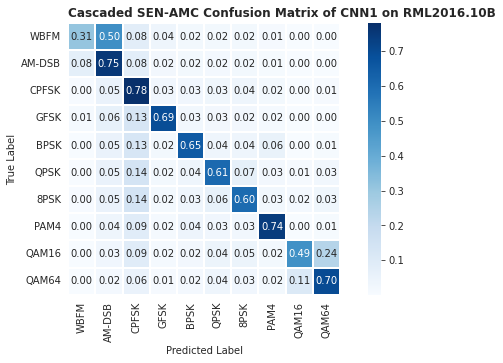

In [ ]:
cmn = compute_cascadedModel_confusion(sen_model=sen_model, high_snr_model = model_highSNR,
                                      med_snr_model = model_medSNR, low_snr_model = model_lowSNR,
                                      data=test, le=le)

title = "Cascaded SEN-AMC Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
plt.show()